# Práctica 11: RNNs

## Pre-requisitos

### Instalar paquetes

Si la práctica requiere algún paquete de Python, habrá que incluir una celda en la que se instalen. Si usamos un paquete que se ha utilizado en prácticas anteriores, podríamos dar por supuesto que está instalado pero no cuesta nada satisfacer todas las dependencias en la propia práctica para reducir las dependencias entre ellas.

### NOTA: En <font color='red'>Google Colab</font> hay que instalar los paquetes EN CADA EJECUCIÓN

In [2]:
# Ejemplo de instalación de tensorflow 2.0
#%tensorflow_version 2.x
# !pip3 install tensorflow  # NECESARIO SOLO SI SE EJECUTA EN LOCAL
import tensorflow as tf

# Hacemos los imports que sean necesarios
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import datetime

# Pronóstico de series de tiempo

Vamos a utilizar un [conjunto de datos de series de tiempo meteorológicas](https://www.bgc-jena.mpg.de/wetter/) registradas por el Instituto Max Planck de Biogeoquímica.

Este conjunto de datos contiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Estos se recopilaron cada 10 minutos, de 2009 a 2016.

Lo primero que vamos a hacer es cargar los datos en un DataFrame de la librería [Pandas](https://pandas.pydata.org/).

En Keras tenemos implementado tanto las capas recurrentes [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) y [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Sin embargo, es posible crear cualquier capa recurrente que queramos de una manera sencilla. Basta con crear una capa (llamada celda) que indique las operaciones a realizar, y luego encapsularla en la capa [RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN).

Por tanto, en esta clase vamos a tratar de replicar la celda de la capa GRU.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)[::6]

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Visualización de los datos

Antes de nada, vamos a echar un vistazo a los datos.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
12,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
18,01.01.2009 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
24,01.01.2009 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


También podemos ver como cambian los datos de las variables a lo largo del tiempo

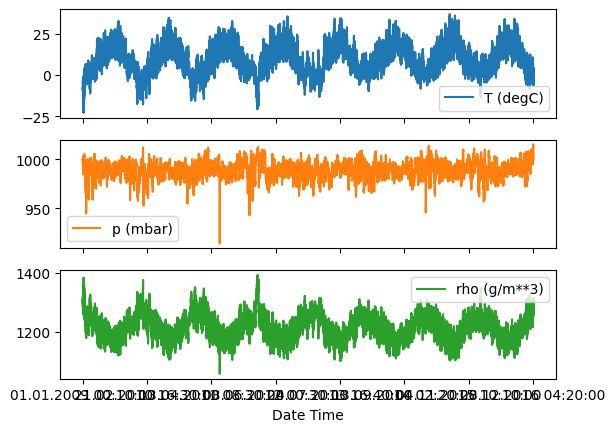

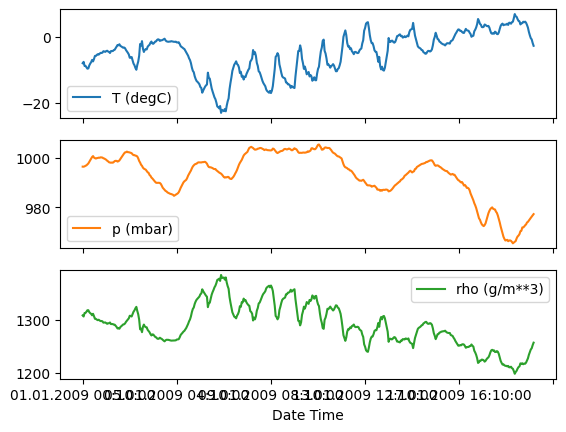

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = df['Date Time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df['Date Time'][:480]
_ = plot_features.plot(subplots=True)

## Preprocesado de los datos

Primero de nada, vamos a observar las estadísticas de cada dato. Para ello, la librería Pandas nos permite obtener información de una manera muy sencilla.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70092.0,989.212830,8.358709,914.10,984.20,989.58,994.72,1015.28
T (degC),70092.0,9.450272,8.423862,-23.01,3.36,9.42,15.47,37.13
Tpot (K),70092.0,283.492874,8.504928,250.60,277.43,283.47,289.53,311.06
Tdew (degC),70092.0,4.955267,6.730338,-25.01,0.23,5.22,10.06,23.11
rh (%),70092.0,76.005225,16.477654,14.20,65.21,79.30,89.40,100.00
VPmax (mbar),70092.0,13.576563,7.739742,0.95,7.78,11.82,17.60,63.26
VPact (mbar),70092.0,9.533275,4.183679,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),70092.0,4.043228,4.898197,0.00,0.87,2.19,5.30,45.42
sh (g/kg),70092.0,6.022089,2.655839,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),70092.0,9.639723,4.234911,0.80,6.28,8.96,12.48,28.82


### Limpiar el dataset
En los datos podemos ver cosas extrañas. Por ejemplo, en la velocidad **wv** tenemos, como dato mínimo, valores de -9999m/s, que es una velocidad absurda. En este caso tenemos dos opciones:

1. Eliminar las filas con el error.
1. Poner un dato más fiable.

En nuestro caso, vamos a decidirnos por la última, sustituyendo cualquier valor menor que 0 por un 0.


In [7]:
## TODO: sustituye los datos negativos de las columnas wv (m/s) y max. wv (m/s) por 0's
wv = df['wv (m/s)']
wv_negativos = wv < 0
wv[wv_negativos] = 0

wv_max = df['max. wv (m/s)']
wv_max_negativos = wv_max < 0
wv_max[wv_max_negativos] = 0


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70092.0,989.212830,8.358709,914.10,984.20,989.58,994.72,1015.28
T (degC),70092.0,9.450272,8.423862,-23.01,3.36,9.42,15.47,37.13
Tpot (K),70092.0,283.492874,8.504928,250.60,277.43,283.47,289.53,311.06
Tdew (degC),70092.0,4.955267,6.730338,-25.01,0.23,5.22,10.06,23.11
rh (%),70092.0,76.005225,16.477654,14.20,65.21,79.30,89.40,100.00
VPmax (mbar),70092.0,13.576563,7.739742,0.95,7.78,11.82,17.60,63.26
VPact (mbar),70092.0,9.533275,4.183679,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),70092.0,4.043228,4.898197,0.00,0.87,2.19,5.30,45.42
sh (g/kg),70092.0,6.022089,2.655839,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),70092.0,9.639723,4.234911,0.80,6.28,8.96,12.48,28.82


Si la operación se ha completado satisfactoriamente, puedes volver a evaluar las estadísticas del dataset para comprobar que se han modificado los valores.

### Transformación de datos

So observamos los datos vemos que tenemos ciertos componentes que necesitan ser preprocesados para evitar errores innecesarios.

#### Viento

El viento se compone de las 3 últimas variables. En especial la última, **wd (deg)**, que marca la dirección del viento. ¿Cuál es el problema que contiene esta variable? Tómate un tiempo para evaluar la problemática.

<font color='red'>TODO:</font> Escribe aquí el motivo por el que crees que la variable **wd (deg)** puede ser problemática en su forma actual.



¿Ya te has dado cuenta del problema? ¡Es hora de arreglarlo! Sustituye el dato por una representación más útil.

<font color='red'>PISTA:</font> la solución implica dividir la variable en dos nuevos campos.

In [9]:
# Convertimos los grados a radianes
wd_rad = df.pop('wd (deg)')*np.pi / 180

# TODO: modifica wd (deg) para obtener una mejor representación
# Crea los nuevos componentes e insértalos en el dataframe.

# Calcular las componentes x e y del vector de dirección del viento
df['wd_x'] = np.cos(wd_rad)
df['wd_y'] = np.sin(wd_rad)

#### Fecha

La fecha es también algo muy importante en los datos, pero hay que tener en cuenta su periodicidad. En concreto, dos casos:

- Periodicidad en la hora del día.
- Periodicidad en la época del año.

Un método simple para convertirlo en una señal utilizable es usar el [seno](https://numpy.org/doc/stable/reference/generated/numpy.sin.html) y el [coseno](https://numpy.org/doc/stable/reference/generated/numpy.cos.html) para convertir la hora en señales claras de "Hora del día" y "Hora del año". Hay que operar de tal manera que:

1. $\cos(hora~0) = \cos(hora~24)$ y $\sin(hora~0) = \sin(hora~24)$ en la hora del día.
1. $\cos(1~enero) \approx \cos(31~diciembre)$ y $\sin(1~enero) \approx \sin(31~diciembre)$ en la hora anual.

<font color='red'>PISTA:</font> recuerda que:
- $\cos(0) = \cos(2\pi)$.
- $\sin(0) = \sin(2\pi)$.

In [10]:
# Vamos a quitar la columna de la fecha
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Lo convertimos en segundos
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# TODO: calcula el número de segundos de un día y de un año
day = 24 * 60 * 60
year = 365.2425 * day


# TODO: Extrae, para cada fecha, el seno y el coseno, y añádelos al dataframe
df['Dia sin'] = np.sin(2 * np.pi * (timestamp_s % day) / day)
df['Dia cos'] = np.cos(2 * np.pi * (timestamp_s % day) / day)
df['Anho sin'] = np.sin(2 * np.pi * (timestamp_s % year) / year)
df['Anho cos'] = np.cos(2 * np.pi * (timestamp_s % year) / year)

## Partición de datos

Usaremos una división **(70%, 20%, 10%)** para los conjuntos de entrenamiento, validación y prueba. Tenga en cuenta que los datos **no** se mezclan aleatoriamente antes de dividirlos. Esto es por dos razones:

1. Garantiza que aún sea posible dividir los datos en ventanas de muestras consecutivas.
1. Garantiza que los resultados de la validación / prueba sean más realistas y se evalúen en función de los datos recopilados después de que el modelo haya sido entrenado.

In [11]:
# TODO: parte los datos según el porcentaje estipulado
n_datos = len(df)

train_size = int(n_datos * 0.7)
val_size = int(n_datos * 0.2)

# Dividir los datos
train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Normalización de los datos

Para que una red neuronal entrene correctamente suele ser necesario que todos los datos tengan una misma escala, o al menos una parecida. Sin embargo, anteriormente hemos visto como algunas variables tienen medias cercanas a 1000, mientras que otras rondan el 0. Por tanto, necesitamos igualarlas.

Existen múltiples maneras de escalar los datos, pero una de las más comunes es la normalización:

$$ \tilde{x} = \dfrac{x - mean(x)}{std(x)} $$

Consiste en restar, **a cada columna**, su media, dividiendo el resultado por su desviación típica. Para realizarlo, podemos hacer uso de las funciones de Pandas [mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) y [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).

Otra cosa a tener en cuenta es que **se usa la media y desviación del conjunto de entrenamiento** para normalizar todos los datos. Esto es así porque es el único conjunto de datos que conoceríamos a priori en un problema real.

In [12]:
# TODO = normaliza los dataframes
train_mean = train_data.mean()
train_std = train_data.std()

train_df = (train_data - train_mean) / train_std
val_df = (val_data - train_mean) / train_std
test_df = (test_data - train_mean) / train_std


Ahora podemos observar como los datos están más o menos balanceados, y todos en la misma escala.

<ipython-input-13-bd778f9a5ff3>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


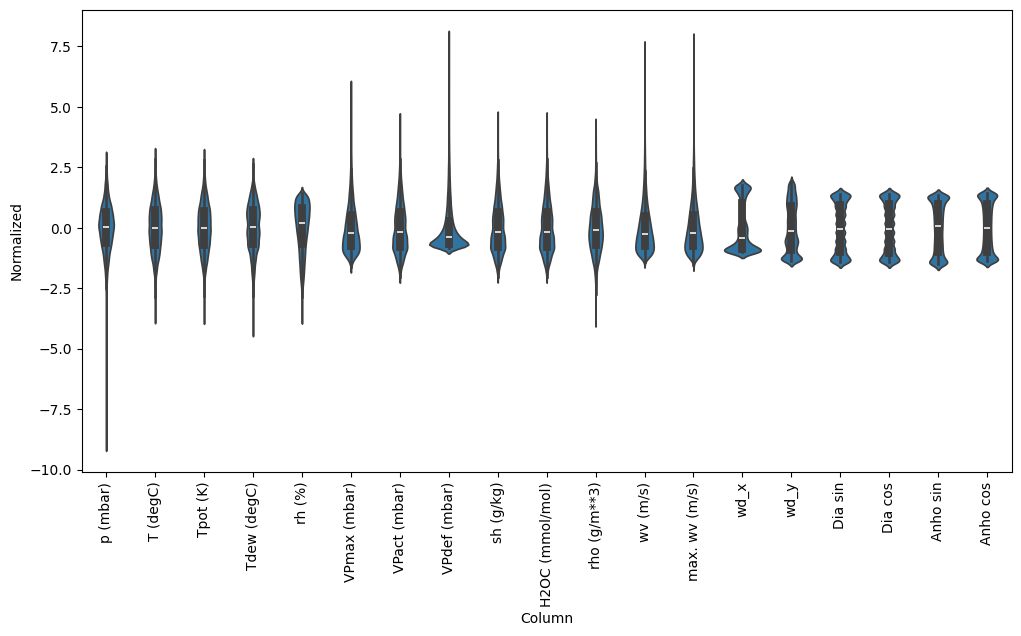

In [13]:
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Ventana de datos

Los modelos de esta práctica harán un conjunto de predicciones basadas en una ventana de muestras consecutivas de los datos. La agrupación de los datos se determinará mediante 3 parámetros:

1. **Anchura de la entrada (input_width):** Es el número de datos de diferentes tiempos que vamos a meter en el modelo.
1. **Anchura de la salida (label_width):** Es el número de datos de diferentes tiempos que vamos a tratar de predecir.
1. **Retardo de la salida (offset):** Es el tiempo a pasar entre el último dato de la entrada y el primero de la salida.

Aquí podemos ver una serie de distintos ejemplos:

`input_width = 5, label_width = 1, offset = 1`

<img src="./img/ventana1.png" alt="Ventana de ejemplo 1" width="400"/>


`input_width = 24, label_width = 4, offset = -2`

<img src="./img/ventana2.png" alt="Ventana de ejemplo 2" width="400"/>


El objetivo de esta parte es **crear una función que divida el dataset de entrada en todos los segmentos posibles de entrada/salida**, teniendo en cuenta los 3 parámetros mencionados anteriormente.

In [14]:
# TODO: completa la función sliding_window, sustituyendo las partes con None

def sliding_window(data, labels, input_width, label_width=1, offset=0):
    x = []
    y = []

    # Corrección en el rango del bucle
    for i in range(len(data) - input_width - label_width - offset + 1):
        # Seleccionar la ventana de entrada y etiquetas
        _x = data[i:i + input_width]
        _y = labels[i + input_width + offset:i + input_width + offset + label_width]
        x.append(_x)
        y.append(_y)

    # Convertir a numpy arrays
    x, y = np.array(x), np.array(y)

    # Añadir nueva dimensión si es necesario
    if len(x.shape) == 2:  # Si x es 2D, hazlo 3D
        x = x[:, :, np.newaxis]

    if len(y.shape) == 2:  # Si y es 2D, hazlo 3D
        y = y[:, :, np.newaxis]

    return x, y

# Prueba el código
prueba_x, prueba_y = sliding_window(np.arange(5), np.arange(5), input_width=3, label_width=2, offset=-2)
print((prueba_x, prueba_y)) # La salida esperada es (array([[[0], [1], [2]], [[1], [2], [3]], [[2], [3], [4]]]), array([[[1], [2]], [[2], [3]], [[3], [4]]]))
assert(prueba_x.shape == (3, 3, 1) and prueba_y.shape == (3, 2, 1))

(array([[[0],
        [1],
        [2]],

       [[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]]]), array([[[1],
        [2]],

       [[2],
        [3]],

       [[3],
        [4]]]))


Una vez creada la función, se la pasamos a nuestros datos. Primero, definimos los parámetros de la función.

In [15]:
input_width = 24
label_width = 24
offset = -input_width + 1
target_labels = 'T (degC)' # Vamos a tratar de predecir la temperatura


# TODO: Llama a la función para dividir el dataset
x_train, y_train = sliding_window(
    train_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    train_df[target_labels].values,
    input_width=input_width,
    label_width=label_width,
    offset=offset
)
x_val, y_val = sliding_window(
    val_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    val_df[target_labels].values,
    input_width=input_width,
    label_width=label_width,
    offset=offset
)
x_test, y_test = sliding_window(
    test_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    test_df[target_labels].values,
    input_width=input_width,
    label_width=label_width,
    offset=offset
)



Vamos a comprobar el tamaño de los datos.

In [16]:
print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)
print('x_train shape :', x_val.shape)
print('y_train shape :', y_val.shape)
print('x_test shape :', x_test.shape)
print('y_test shape :', y_test.shape)

x_train shape : (49040, 24, 18)
y_train shape : (49040, 24, 1)
x_train shape : (13994, 24, 18)
y_train shape : (13994, 24, 1)
x_test shape : (6986, 24, 18)
y_test shape : (6986, 24, 1)


## Creando el modelo

Una vez obtenido un correcto preprocesado de los datos, vamos a crear el modelo. Nuestro primer modelo constará de dos partes:

1. Capa recurrente ([LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM))
1. Capa densa, para adecuar la salida al tamaño esperado.

Un argumento de constructor importante para todas las capas de keras RNN (como LSTM) es el argumento `return_sequences`. Este parámetro puede configurar la capa de dos formas.

1. Si es `False` (el valor por defecto) la capa solo devuelve el resultado del paso de tiempo final, lo que le da tiempo al modelo para calentar su estado interno antes de hacer una sola predicción:

<img src="./img/lstm_1_window.png" alt="LSTM 1 predicción" width="400"/>

2. Si es `True` la capa devuelve una salida para cada entrada:

<img src="./img/lstm_many_window.png" alt="LSTM múltiples predicciones" width="400"/>

Esto es útil para:
  * Apilamiento de capas RNN.
  * Entrenamiento de un modelo en múltiples pasos de tiempo simultáneamente.

En nuestro caso, hemos definido nuestros datos con solapamiento, con el objetivo de entrenar nuestro modelo en múltiples pasos.

In [17]:
# TODO: Completa el modelo con las partes necesarias
import tensorflow as tf
from tensorflow import keras

lstm_model = tf.keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences = True), # Capa recurrente (usa un múmero de unidades de la capa oculta de 32, y establece correctamente el valor de return_sequences).
    keras.layers.Dense(1) # Capa densa (escoge correctamente su número de unidades)
])

## Entrenando el modelo

Por último, sólo nos queda entrenar el modelo durante 20 iteraciones. Vamos a utilizar un `callback` llamado [`EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) para que pare el entrenamiento si el resultado en validación no mejora pasadas una serie de iteraciones.

In [18]:
MAX_EPOCHS = 20
batch_size = 32

def entrenar_modelo(model, train_data, train_label, val_data, val_label, epochs, batch_size, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_data, train_label, epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_label),
                        callbacks=[early_stopping])
    return history, model

history = entrenar_modelo(lstm_model, x_train, y_train, x_val, y_val, MAX_EPOCHS, batch_size)


Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0668 - mean_absolute_error: 0.1456 - val_loss: 0.0065 - val_mean_absolute_error: 0.0571
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0065 - mean_absolute_error: 0.0565 - val_loss: 0.0060 - val_mean_absolute_error: 0.0536
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0061 - mean_absolute_error: 0.0539 - val_loss: 0.0057 - val_mean_absolute_error: 0.0520
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0058 - mean_absolute_error: 0.0525 - val_loss: 0.0056 - val_mean_absolute_error: 0.0513
Epoch 5/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0057 - mean_absolute_error: 0.0519 - val_loss: 0.0055 - val_mean_absolute_error: 0.0512
Epoch 6/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0515 - val_loss: 0.0056 - val_mean_absolute_error: 0.0508
Epoch 7/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0055 - mean_absolute

### Visualizando el resultado

Una vez entrenado el modelo, vamos a ver cómo hace la predicción en test, con respecto al resultado esperado.

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


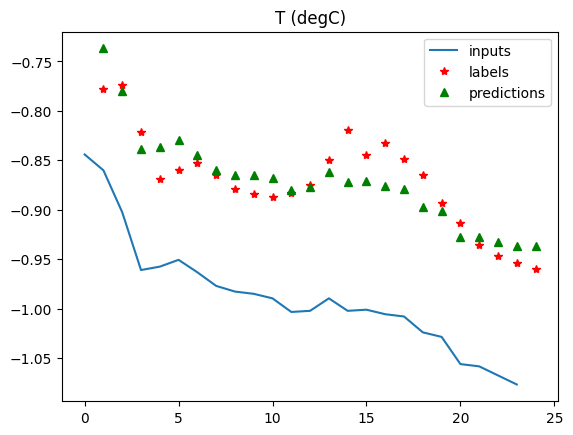

In [19]:
def plot_prediction(feed_data, expected_result, model_result, target_label, offset=1, index=0):

    f_data_x = np.arange(feed_data.shape[1])
    e_data_x = np.arange(expected_result.shape[1]) + offset
    plt.plot(f_data_x, feed_data[index])
    plt.plot(e_data_x, expected_result[index], '*r')
    plt.plot(e_data_x, model_result[index], '^g')
    plt.legend(['inputs', 'labels', 'predictions'])
    plt.title(target_label)

# TODO: predecimos el resultado del test con el modelo
model_result = lstm_model.predict(x_test)

target_index = test_df.columns.get_loc(target_labels)

# TODO: llama a la función plot_prediction con los parámetros correctos
plot_prediction(x_test[:, :, target_index], model_result, y_test, target_labels, label_width + offset, index=0)


La predicción es bastante cercana...pero algo falla. **¡Las temperaturas están mostrando el resultado normalizado!** Revierte la normalización para un correcto visualizado.

In [23]:
# TODO: llama a la función plot_prediction con los valores sin normalizar
def denormalize(data, mean, std):
    return (data * std) + mean

# Desnormalizar los valores reales y predichos
y_train_true = denormalize(y_train, train_mean[target_labels], train_std[target_labels])  # Valores reales
y_train_pred = denormalize(model_result, train_mean[target_labels], train_std[target_labels])  # Predicciones del modelo

# Llamar a la función de graficar
plot_prediction(y_train_true, y_train_pred)

TypeError: plot_prediction() missing 2 required positional arguments: 'model_result' and 'target_label'

¡Enhorabuena! Has creado tu primera red recursiva. Ahora vamos a hacerlo un poco más complejo.

# Predicción de múltiples pasos a futuro

El modelo que vimos anteriormente utiliza la salida de cada entrada del LSTM para predecir el tiempo siguiente.

**¿Qué pasaría entonces si uso el mismo modelo para predecir la temperatura en las 24h siguientes?** Si usásemos el mismo modelo, la predicción de la temperatura en el la hora 25 sólo tomaría en cuenta los datos de la temperatura de la primera hora, en lugar de las 24h que tenemos registradas. Por tanto, tendremos que hacer unos cambios en nuestro modelo.

In [24]:
input_width = 24
label_width = 24
offset = 1
target_labels = 'T (degC)' # Vamos a tratar de predecir la temperatura


# TODO: Llama a la función para dividir el dataset
x_train, y_train = sliding_window(
    train_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    train_df[target_labels].values,
    input_width=input_width,
    label_width=label_width)

x_val, y_val = sliding_window(
    val_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    val_df[target_labels].values,
    input_width=input_width,
    label_width=label_width)
x_test, y_test = sliding_window(
    test_df.drop(columns=target_labels).values,  # Datos de entrada sin la etiqueta objetivo
    test_df[target_labels].values,
    input_width=input_width,
    label_width=label_width)

## Creando el modelo

En este modelo vamos a necesitar acumular la información de las 24h de entrada para empezar a predecir los resultados a la salida. El esquema a seguir es el siguiente:

<img src="./img/multistep_lstm.png" alt="LSTM 1 predicción" width="400"/>

Por tanto, debemos hacer un cambio en el argumento `return_sequences` que explicamos anteriormente.

A mayores, lo que vamos a hacer es concatenar dos capas LSTM. Para concatenar capas recurrentes, lo que hay que tener en cuenta es que el parámetro `return_sequences=True` tiene que estar activado en todas las capas menos en la última. En dicha capa, el valor de `return_sequences` dependerá de lo que queramos obtener.

In [25]:
# TODO: Completa el modelo con las partes necesarias

lstm_model = tf.keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences = True), # Capa recurrente (usa un múmero de unidades de la capa oculta de 32, y establece correctamente el valor de return_sequences).
    keras.layers.LSTM(32, return_sequences = True), # Capa recurrente (usa un múmero de unidades de la capa oculta de 32, y establece correctamente el valor de return_sequences).

     keras.layers.Dense(1), # # Capa densa (escoge correctamente su número de unidades,
          #                      ya que se necesita una unidad por cada característica de salida que queramos predecir,
#                               y por el número de veces que necesitamos predecir esa característica),
    tf.keras.layers.Reshape((24, 1)) # reorganizamos la salida para que sea del tipo (label_width, n_output_features)
  ])

## Entrenando el modelo

Por último, sólo nos queda entrenar el modelo durante 20 iteraciones.

In [26]:
history = entrenar_modelo(lstm_model, x_train, y_train, x_val, y_val, MAX_EPOCHS, batch_size)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1812 - mean_absolute_error: 0.3171 - val_loss: 0.1211 - val_mean_absolute_error: 0.2724
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1064 - mean_absolute_error: 0.2545 - val_loss: 0.1259 - val_mean_absolute_error: 0.2791
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0994 - mean_absolute_error: 0.2455 - val_loss: 0.1249 - val_mean_absolute_error: 0.2773
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0931 - mean_absolute_error: 0.2371 - val_loss: 0.1310 - val_mean_absolute_error: 0.2828
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0859 - mean_absolute_error: 0.2271 - val_loss: 0.1377 - val_mean_absolute_error: 0.2903
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0816 - mean_absolute_error: 0.2210 - val_loss: 0.1403 - val_mean_absolute_error: 0.2923


### Visualizando el resultado

Una vez entrenado el modelo, vamos a ver cómo hace la predicción en test, con respecto al resultado esperado.

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


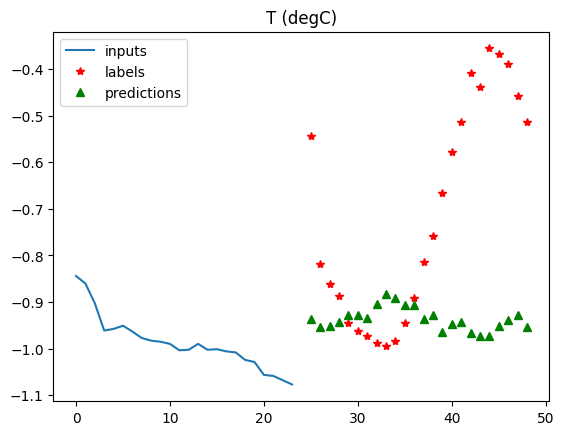

In [27]:
# TODO: predecimos el resultado del test con el modelo
model_result = lstm_model.predict(x_test)

target_index = test_df.columns.get_loc(target_labels)

# TODO: llama a la función plot_prediction con los parámetros correctos
plot_prediction(x_test[:, :, target_index], model_result, y_test, target_labels, label_width + offset, index=0)


Como puedes ver, es muchísimo más difícil predecir el tiempo con mucha antelación.

# ¡ENHORABUENA! Has completado la práctica de Redes recurrentes.

# ¿Deseas saber más?

La redes recursivas también permiten la predicción a posteriori, utilizando como datos de entradas las mismas predicciones de la red en tiempos anteriores. Son las llamadas [redes auto-regresivas](https://eigenfoo.xyz/deep-autoregressive-models/).

# Trabajo extra

Como trabajo extra, se propone realizar una idea parecida, pero con dificultad añadida.

- Se utilizará una capa [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) en lugar de la LSTM.
- Se propone predecir todas las variables del dataset al mismo tiempo, en lugar de sólo la temperatura.

In [ ]:
# TODO: escribe el código para el trabajo extra sin ayuda. Usa todos los bloques de código que quieras.